In [2]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


import reflexmotion as rm

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from astropy.io import fits


In [3]:
def spatial_distance(ra1,ra2,dec1,dec2):
    """compute a simple spherical onsky distance"""
    
    deltara  = 15.*np.cos(dec1)*np.abs(ra1-ra2)
    deltadec = np.abs(dec1-dec2)
    
    return np.sqrt(deltara*deltara + deltadec*deltadec)
    

In [4]:

#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)




In [58]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html
def return_gaia_Ag():
    """set the Hipparcos computation

    if truly obsessed see https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf

    though this has higher precision!!
    """
    return np.array([[-0.0548755604162154,+0.4941094278755837,-0.8676661490190047],
                     [-0.8734370902348850,-0.4448296299600112,-0.1980763734312015],
                     [-0.4838350155487132,+0.7469822444972189,+0.4559837761750669]])

    

def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)])

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    if hasattr(a,'size'):
        return np.array([-np.sin(a),np.cos(a),np.zeros(a.size)])
    else:
        return np.array([-np.sin(a),np.cos(a),0.])

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)])

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return p*mua + q*mud



def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)])

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    if hasattr(l,'size'):
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])
    else:
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)])

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return p*mul + q*mub


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.sum(p*mugal,axis=0)
    mub = np.sum(q*mugal,axis=0)
    #print(mul,mub)
    return mul,mub





def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)
    
    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])

    if hasattr(a,'size'):
        G = np.einsum('anb,acn->nbc', pqgal,
                      np.einsum('ji,ink->jkn', return_gaia_Agprime(), pqicrs))

        cov_to = np.einsum('nba,nac->nbc', G,
                           np.einsum('ijn,nki->njk', cov, G))
        
    else:
        G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

        cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

    

def rotate_positions(a,d,dist):
    """eq 3.68, but built for speed"""
    # solve for positions
    if a.size>1:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = dist*rgal        
    else:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = np.dot(dist,rgal)        
    return cpos

def rotate_galactic(a,d):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    return ell,b


def rotate_observed(l,b):
    """eq 3.68, THIS DOES NOT WORK FOR b=90 (exactly)!"""
    # solve for positions
    rgal = return_rgal(l,b)
    ricrs = np.dot(return_gaia_Ag(),rgal)
    #d = np.arcsin(ricrs[2])
    #a = np.arccos(ricrs[0]/np.cos(d))
    #print(a,d)

    # implement eq 3.63
    a,d = np.arctan2(ricrs[1],ricrs[0]),np.arctan2(ricrs[2],np.sqrt(ricrs[0]*ricrs[0]+ricrs[1]*ricrs[1]))

    return a,d


def rotate_velocities_observed(l,b,mul,mub):
    """eq 3.68, """
    mu = return_mugal(l,b,mul,mub)
    muicrs = np.dot(return_gaia_Ag(),mu) # eq. 3.68
    
    rgal = return_rgal(l,b)
    ricrs = np.dot(return_gaia_Ag(),rgal)
    a,d = np.arctan2(ricrs[1],ricrs[0]),np.arctan2(ricrs[2],np.sqrt(ricrs[0]*ricrs[0]+ricrs[1]*ricrs[1]))
    
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    
    mua = np.sum(p*muicrs,axis=0)
    mud = np.sum(q*muicrs,axis=0)
    #print(mul,mub)
    return mua,mud


a = 70.*np.pi/180.
d = 89.99*np.pi/180.
mua = -10.
mud = 1.

#print(return_muicrs(a,d,mua,mud))


print(mua,mud)
print(rotate_velocities(a,d,mua,mud))
l,b = rotate_galactic(a,d)
mul,mub = rotate_velocities(a,d,mua,mud)
#print(rotate_galactic(a,d))
print(rotate_velocities_observed(l,b,mul,mub))

#cov_to = rotate_errors(a,d,1,2.,0.)
#print(cov_to)


#print(ricrs,rgal,ell,b)

-10.0 1.0
(-6.266399187466095, -7.856986777596376)
(array([-10.]), 0.9999999999910104)


In [33]:

# now with RUWE!
Gmatch = np.genfromtxt('/Users/mpetersen/Downloads/variables_with_ruwe-result.csv',\
                        dtype={'names': ("pmdec_error","dec","radial_velocity_error","pmra_pmdec_corr",\
                                    "parallax","best_class_name","teff_val","parallax_error","phot_g_mean_flux",\
                                    "phot_bp_mean_flux_error","ra","phot_bp_mean_flux","phot_g_mean_flux_error",\
                                    "best_class_score","radial_velocity","bp_rp","dec_error",\
                                    "pmra","pmdec","a_g_val",\
                                    "ra_error","pmra_error","phot_g_mean_mag","ruwe","source_id"),\
                             'formats': ('f8','f8','f8','f8',\
                                         'f8','S20','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8',\
                                         'f8','f8','f8','f8','S20')},\
                 skip_header=1,delimiter=',')



In [ ]:

# filter
pmatch = np.where(np.isfinite(Gmatch['pmra']) & \
                  np.isfinite(Gmatch['pmdec']) & \
                  (Gmatch['ruwe'] < 1.4) &\
                  ( (Gmatch['best_class_name']==b'RRAB') | \
                    (Gmatch['best_class_name']==b'RRC') | \
                    (Gmatch['best_class_name']==b'RRD') | \
                    (Gmatch['best_class_name']==b'ARRD') ))[0]

print(pmatch.size)




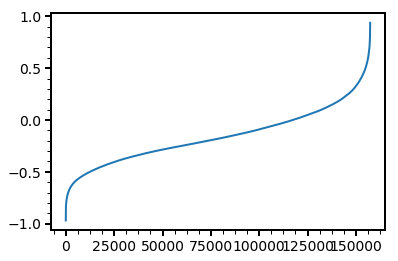

In [107]:
# compute the galactic positions
# do all velocity transforms

l,b = rotate_galactic(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.)

l[l<0] += 2.*np.pi

e1 = Gmatch['pmra_error'][pmatch]
e2 = Gmatch['pmdec_error'][pmatch]
e3 = Gmatch['pmra_pmdec_corr'][pmatch]
cov_to = rotate_errors(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.,\
                       e1,e2,e3)

corrcoef = np.array([cov_to[i][0][1]/(np.sqrt(cov_to[i][0][0])*np.sqrt(cov_to[i][1][1])) for i in range(0,len(pmatch))])
pm_l_err = np.array([np.sqrt(cov_to[i][0][0]) for i in range(0,len(pmatch))])
pm_b_err = np.array([np.sqrt(cov_to[i][1][1]) for i in range(0,len(pmatch))])

pm_l,pm_b = rotate_velocities(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.,\
                              Gmatch['pmra'][pmatch],Gmatch['pmdec'][pmatch])

plt.plot(corrcoef[corrcoef.argsort()])



In [108]:
np.nanmax(l)

6.283184878270929

In [109]:
# compute the extinctions

import dustmaps
#from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

#l = RRL1[:,6]
#b = RRL1[:,7]

coords = SkyCoord(l*(180./np.pi), b*(180./np.pi), unit='deg', frame='galactic')

#planck = PlanckQuery()
#planck(coords)
#>>> array([ 0.50170666,  1.62469053,  0.29259142])

sfd = SFDQuery()
extvals = sfd(coords)
print(extvals.size)
#>>> array([ 0.55669367,  2.60569382,  0.37351534], dtype=float32)

157347


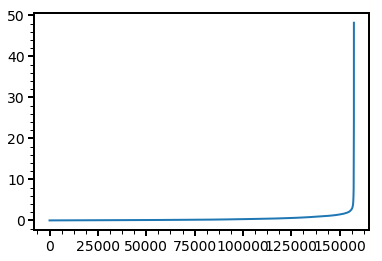

In [110]:
plt.plot(extvals[extvals.argsort()])

(0.0, 50.0)

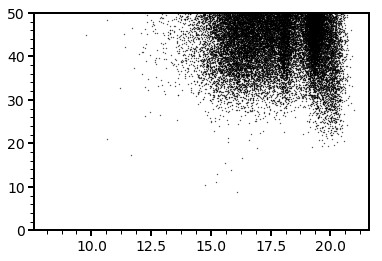

In [131]:
plt.scatter(Gmatch['phot_g_mean_mag'][pmatch],(Gmatch['phot_g_mean_flux']/Gmatch['phot_g_mean_flux_error'])[pmatch],color='black',s=0.1)

plt.ylim([0.,50.])


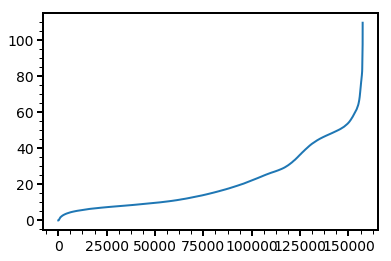

In [111]:

# compute the distance
zeropoint = 0.64 # this is M_G from Iorio 2018

# 2.27E(B-V) is the correction from Iorio

dist = 10.**(((Gmatch['phot_g_mean_mag'][pmatch]-2.27*extvals-zeropoint)/5) - 2.)
#plt.plot(dist[dist.argsort()])


ezeropoint = 0.25
dist2 = 10.**(((Gmatch['phot_g_mean_mag'][pmatch]-2.27*extvals-zeropoint+ezeropoint)/5) - 2.)

#plt.plot(dist2[dist2.argsort()])


dtest = np.where(extvals<100.)

plt.plot((dist[dtest])[dist[dtest].argsort()])





In [133]:
dist2[0]/dist[0]

1.1220184543019631

In [112]:
# cross match to known position contaminants

In [113]:
# SGR

cols = ["dr2","gmag","dist","edist",\
        "ra","dec","pmra","pmra_error",\
        "pmdec","pmdec_error","glon",\
        "glat","pm_l","pm_l_error",\
        "pm_b","pm_b_error","glon_s","glat_s",\
        "pm_glon_s","pmglon_s_error","pm_glat_s","pm_glat_s_error",\
        "vl","evl","vb","evb","SOStype",\
        "PS1type","VCtype","inputcat","sample"]

bytelog = [0,19,27,33,38,\
           54,70,80,86,\
           96,102,117,132,\
           139,145,152,158,\
           170,181,188,194,\
           201,207,216,224,232,240,245,250,255,259,262]

dtypes=  ['S20','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8',\
                                        'f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','S20',\
                                        'S20','S20','S20','S20']

print(len(cols),len(bytelog),len(dtypes))


Ramos = {}
for key in cols:
    Ramos[key] = []

linenum = 0
with open('/Users/mpetersen/Downloads/tablee.dat') as openfileobject:
    for line in openfileobject:
        linenum+=1
        if linenum>141:
            for icol,col in enumerate(cols):
                Ramos[col].append(line[bytelog[icol]:bytelog[icol+1]].strip())
        
for icol,key in enumerate(cols):
    Ramos[key] = np.array(Ramos[key]).astype(dtypes[icol])


# identify the overlapping catalog members
overlap = 0
olap1 = np.zeros(len(pmatch))
olap2 = np.zeros(len(pmatch))

for i in range(0,len(Ramos['dr2'])):
    w = np.where(Ramos['dr2'][i]==Gmatch['source_id'][pmatch])[0]
    if len(w)>0:
        if ((Ramos['sample'][i] == b'11') | (Ramos['sample'][i] == b'10')):
            olap1[w[0]] = 1
        else:
            olap2[w[0]] = 1

        overlap+=1
        
        
print(overlap,np.sum(olap1),np.sum(olap2))

31 32 31
9540 5789.0 3751.0


In [114]:
# also compute a transformation to Sgr

cbest = coord.SkyCoord(ra              = Gmatch['ra'][pmatch]    * u.deg,\
                       dec             = Gmatch['dec'][pmatch]   * u.deg,\
                       distance        = dist  * u.kpc,\
                       pm_ra_cosdec    = Gmatch['pmra'][pmatch]   * u.mas/u.yr,\
                       pm_dec          = Gmatch['pmdec'][pmatch]   * u.mas/u.yr)


#best_defined = cbest.transform_to(gc_frame)
best_sgr     = cbest.transform_to(Sagittarius)
best_latlon  = cbest.transform_to('galactic')

ltmp = np.copy(l)
ltmp[ltmp<0] += 2.*np.pi

print(np.array(best_latlon.l)-ltmp*(180./np.pi))
print(np.array(best_latlon.b)-b*(180./np.pi))


print(np.nanmax(np.array(best_latlon.l)-ltmp*(180./np.pi)))

[6.20832270e-06 6.20813489e-06 6.20805650e-06 ... 6.35647203e-06
 6.35977310e-06 6.36546767e-06]
[-3.04933223e-06 -3.04978121e-06 -3.04984148e-06 ... -2.24576566e-06
 -2.24083158e-06 -2.23936042e-06]
0.0003490381560311562


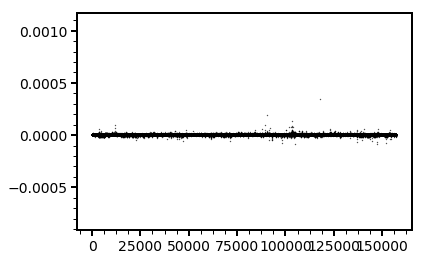

In [115]:
#plt.plot(np.array(best_latlon.l)[np.array(best_latlon.l).argsort()])

ldiff = np.array(best_latlon.l)-ltmp*(180./np.pi)
plt.scatter(np.array(best_latlon.l).argsort(),ldiff,color='black',s=0.1)

In [116]:
# LMC/SMC
# make cuts around the LMC/SMC positions
xp,yp,zp = rotate_positions(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.,dist)


lmcx = -0.62
lmcvx = -39.47
lmcy = -42.11
lmcvy = -229.29
lmcz = -27.69
lmcvz = 230.24
    
smcx = 16.35
smcvx = 7.77
smcy = -38.5
smcvy = -191.2 
smcz = -44.76
smcvz = 171.71

rlmc = np.sqrt((xp-lmcx)**2. + (yp-lmcy)**2. + (zp-lmcz)**2.)
rsmc = np.sqrt((xp-smcx)**2. + (yp-smcy)**2. + (zp-smcz)**2.)
rlmcsmc = np.sqrt((lmcx-smcx)**2. + (lmcy-smcy)**2. + (lmcz-smcz)**2.)
print(rlmcsmc)



24.339225542321596


46.630495579523505
59.36911152073862
21781
2674


[0, 360, -90, 90]

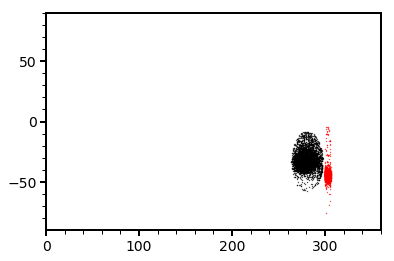

In [117]:
w = np.where(rlmc<20)
#llmc,blmc,dlmc = np.nanmedian(RRL1[w,6]),np.nanmedian(RRL1[w,7]),np.nanmedian(RRL1[w,8])
llmc,blmc,dlmc =280.4652, -32.8884,np.nanmedian(dist[w])
print(dlmc)

w = np.where(rsmc<10)
#lsmc,bsmc,dsmc = np.nanmedian(RRL1[w,6]),np.nanmedian(RRL1[w,7]),np.nanmedian(RRL1[w,8])
lsmc,bsmc,dsmc =302.8084,-44.3277,np.nanmedian(dist[w])
print(dsmc)

sp_dist = spatial_distance(llmc,ltmp*(180./np.pi),blmc,b*(180./np.pi))
w = np.where( (sp_dist<25.) & (dist+25 > dlmc))[0]
print(w.size)
lmcflag = np.zeros(dist.size)
lmcflag[w] += 1

plt.scatter(ltmp[w]*(180./np.pi),b[w]*(180./np.pi),color='black',s=0.1)

sp_dist = spatial_distance(lsmc,ltmp*(180./np.pi),bsmc,b*(180./np.pi))
w = np.where( (sp_dist<45.) & (dist+20 > dsmc))[0]
print(w.size)
smcflag = np.zeros(dist.size)
smcflag[w] += 1

plt.scatter(ltmp[w]*(180./np.pi),b[w]*(180./np.pi),color='red',s=0.1)

plt.axis([0,360,-90,90])



In [118]:
# all satellites
InN = np.genfromtxt('processed/satellites_mcconnachie.txt',skip_header=1,dtype='S20')
names = InN[:,16]
In = np.genfromtxt('processed/satellites_mcconnachie.txt',skip_header=1)


xsat    = In[:,0]
ysat    = In[:,1]
zsat    = In[:,2]
vxsat   = In[:,3]
vysat   = In[:,4]
vzsat   = In[:,5]
lsat    = In[:,6]
bsat    = In[:,7]
dsat    = In[:,8]

nsats = xsat.size
#print(nsats)
#print(names)

memberdict = dict()
sat_member = np.zeros(dist.size)

for sat in range(0,nsats):
    sp_dist = spatial_distance(lsat[sat],l*(180./np.pi),bsat[sat],b*(180./np.pi))
    w = np.where( (sp_dist<5.) & (dist+20 > dsat[sat]))[0]
    memberdict[names[sat].decode()] = w
    sat_member[w] += 1
    print(names[sat].decode(),w.size)

#plt.scatter(xsat,zsat,color='black',s=3.)

Antlia2 0
Aquarius2 0
Bootes1 4
Bootes2 1
CanesVenatici1 0
CanesVenatici2 0
Carina 6
Carina2 57
Carina3 32
Columba1 0
ComaBerenices 1
Crater2 0
Draco 102
Draco2 8
Eridanus2 0
Fornax 0
Grus1 0
Grus2 8
Hercules 0
Horologium1 1
Horologium2 0
Hydra2 0
Hydrus1 42
Leo1 0
Leo2 0
Leo4 0
Leo5 0
LeoT 0
Phoenix 0
Phoenix2 1
Pisces2 0
Reticulum2 5
Reticulum3 0
Sagittarius2 4
Sculptor 263
Segue1 4
Segue2 1
Sextans1 18
Triangulum2 16
Tucana2 4
Tucana3 3
Tucana4 5
Tucana5 8
UrsaMajor1 3
UrsaMajor2 6
UrsaMinor 67


In [119]:
# all GCs
V19 = np.genfromtxt('/Users/mpetersen/Notebooks/Dynamics/Shells/data/Vasiliev19.txt',\
                        dtype={'names': ("Name","OName","ra","dec",\
                                         "dist","HRV","e_HRV","pmra",\
                                         "pmdec","e_pmra","e_pmdec","corr",\
                                         "rscale","Nstar","SimbadName"),\
                             'formats': ('S20','S20','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','S20')},\
                 skip_header=61,delimiter=';')




memberdictGC = dict()


gc_member = np.zeros(dist.size)

for gc in range(0,V19['Name'].size):
    if V19['Name'][gc].decode().strip()=='NGC 6652': continue
    gc_dist = spatial_distance(V19['ra'][gc],l*(180./np.pi),V19['dec'][gc],b*(180./np.pi))
    w = np.where( (gc_dist<2.) & (dist+10 > V19['dist'][gc]))[0]
    memberdictGC[V19['Name'][gc].decode().strip()] = w
    gc_member[w] += 1
    print(V19['Name'][gc].decode().strip(),w.size)


    
#plt.scatter(xsat,zsat,color='black',s=3.)

NGC 104 0
NGC 288 60
NGC 362 1
Whiting 1 2
NGC 1261 1
Pal 1 1
E 1 0
Eridanus 0
Pal 2 2
NGC 1851 3
NGC 1904 1
NGC 2298 5
NGC 2419 0
Pyxis 1
NGC 2808 2
E 3 0
Pal 3 0
NGC 3201 3
Pal 4 0
Crater 0
NGC 4147 0
NGC 4372 0
Rup 106 0
NGC 4590 14
NGC 4833 3
NGC 5024 0
NGC 5053 1
NGC 5139 0
NGC 5272 1
NGC 5286 0
NGC 5466 2
NGC 5634 0
NGC 5694 1
IC 4499 0
NGC 5824 0
Pal 5 1
NGC 5897 2
NGC 5904 0
NGC 5927 0
NGC 5946 0
BH 176 0
NGC 5986 0
FSR 1716 0
Pal 14 0
BH 184 1
NGC 6093 3
NGC 6121 3
NGC 6101 0
NGC 6144 0
NGC 6139 2
Terzan 3 0
NGC 6171 2
ESO 452-11 0
NGC 6205 3
NGC 6229 0
NGC 6218 2
FSR 1735 1
NGC 6235 4
NGC 6254 3
NGC 6256 0
Pal 15 0
NGC 6266 3
NGC 6273 3
NGC 6284 0
NGC 6287 1
NGC 6293 7
NGC 6304 2
NGC 6316 1
NGC 6341 1
NGC 6325 7
NGC 6333 0
NGC 6342 2
NGC 6356 1
NGC 6355 3
NGC 6352 2
IC 1257 2
Terzan 2 2
NGC 6366 3
Terzan 4 0
BH 229 12
NGC 6362 1
NGC 6380 13
Terzan 1 4
Ton 2 4
NGC 6388 1
NGC 6402 3
NGC 6401 3
NGC 6397 0
Pal 6 3
NGC 6426 1
Djorg 1 0
Terzan 5 2
NGC 6440 28
NGC 6441 4
Terzan 6 8


In [134]:
# print it all out


f = open('/Users/mpetersen/Dropbox/mike/data/RRL_GaiaI_all_sub_ext.txt','w')

print("x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];       edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];      Ramos Strip [bool]; Ramos Pole [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]; rlmc [kpc]; lmcflag [bool]; rsmc [kpc]; smcflag [bool]; Sat member [bool]; GC member [bool]; extinction [E(B-V)]",file=f)

# olap1 is pole, olap2 is trip
rej = 0
acc = 0
for i in range(0,len(pmatch)):
    #print(np.abs((np.array(best_latlon.b)[i])))
    if (Gmatch['ruwe'][pmatch][i] < 1.4) & (np.abs(np.array(best_latlon.b)[i])>10.):
        print(xp[i],yp[i],zp[i],\
              #np.array(best_defined.v_x)[i],np.array(best_defined.v_y)[i],np.array(best_defined.v_z)[i],\
              0,0,0,\
              l[i]*(180./np.pi),b[i]*(180./np.pi),dist[i],\
              0.,pm_l[i],pm_b[i],\
              0.122*dist[i],0.,pm_l_err[i],pm_b_err[i],\
              olap2[i],olap1[i],0,\
              np.array(best_sgr.Lambda)[i],np.array(best_sgr.Beta)[i],0,\
              corrcoef[i],rlmc[i],lmcflag[i],rsmc[i],smcflag[i],sat_member[i],gc_member[i],extvals[i],file=f)
        acc +=1
    else:
        rej +=1
        #print('REJECTED!')
    
          
f.close()
print(acc,rej)




105866 51481


In [135]:
# test bringing it all back in

infile = '/Users/mpetersen/Dropbox/mike/data/RRL_GaiaI_all_sub_ext.txt'

f=open(infile)
lineraw = f.readline()
line = lineraw.split(';')
for indx,val in enumerate(line):
    print(indx,val)
f.close()

RRL1 = np.genfromtxt(infile,skip_header=1)

0 x [kpc]
1  y [kpc]
2  z [kpc]
3  vx [km/s]
4  vy [km/s]
5  vz [km/s]
6  l [deg]
7  b [deg]
8  dist [kpc]
9  vlos [km/s]
10  dmu_l [marcsec/yr]
11  dmu_b [marcsec/yr]
12        edist[kpc]
13  evlost [km/s]
14  edmu_l [marcsec/yr]
15  edmu_b [marcsec/yr]
16       Ramos Strip [bool]
17  Ramos Pole [bool]
18  FeH [dex]
19  Sgr Lambda [deg]
20  Sgr Beta [deg]
21  Belokurov Flag [bool]
22  corrcoef [-1:1]
23  rlmc [kpc]
24  lmcflag [bool]
25  rsmc [kpc]
26  smcflag [bool]
27  Sat member [bool]
28  GC member [bool]
29  extinction [E(B-V)]



In [136]:
rvals

array([45.75783853, 49.97262056, 41.81416264, ..., 15.7837179 ,
       23.0265612 ,  8.8153865 ])

34789


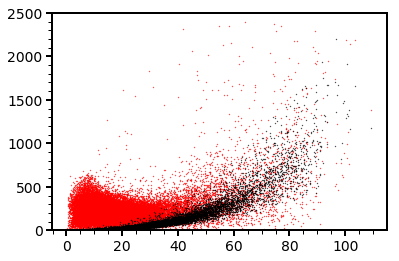

In [137]:
rvals = np.sqrt(RRL1[:,0]*RRL1[:,0] + RRL1[:,1]*RRL1[:,1] + RRL1[:,2]*RRL1[:,2])
#rvals = RRL1[:,8]
rgood = np.where((rvals>0) \
                           & (np.abs(RRL1[:,7])>15*np.pi/180.) \
                           & (RRL1[:,16]==0) \
                           & (RRL1[:,17]==0) \
                           & (RRL1[:,24]==0) \
                           & (RRL1[:,29]<0.1) \
                           & (RRL1[:,26]==0) \
                           & (RRL1[:,27]==0)\
                           & (RRL1[:,28]==0)\
                           & (RRL1[:,23]>30) \
                           & (RRL1[:,25]>20))[0]
print(rgood.size)

#plt.scatter(RRL1[rgood,6],RRL1[rgood,7],color='black',s=0.1)

#rgood = np.where(RRL1[:,24]==1)
#plt.scatter(RRL1[rgood,6],RRL1[rgood,7],color='red',s=0.5)

#rgood = np.where(RRL1[:,26]==1)
#plt.scatter(RRL1[rgood,6],RRL1[rgood,7],color='blue',s=0.5)
k = 4.74057
vphi = RRL1[rgood,8]*k*RRL1[rgood,10]
vtheta = RRL1[rgood,8]*k*RRL1[rgood,11]
vtan = np.sqrt(vphi*vphi + vtheta*vtheta)
evtan = RRL1[rgood,8]*k*np.sqrt(RRL1[rgood,14]*RRL1[rgood,14] + RRL1[rgood,15]*RRL1[rgood,15])


plt.scatter(RRL1[rgood,8],vtan,color='red',s=0.1)
plt.scatter(RRL1[rgood,8],evtan,color='black',s=0.1)

#plt.scatter(RRL1[rgood,8],vtan/evtan,color='red',s=0.1)


#plt.scatter(vtan,evtan,color='black',s=0.1)



plt.ylim(0.,2500.)
#plt.xlim(0.,2500.)


plt.savefig('/Users/mpetersen/Downloads/rrlscatter.png')

In [34]:



a,d = Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.
mua,mud = Gmatch['pmra'][pmatch],Gmatch['pmdec'][pmatch]

a,d,mua,mud = 4.412988523884174, -0.7016329830211496, -9.064863611635216, -5.376376155701305
cov_to = rotate_errors(a,d,mua,mud,0.*mua)
print(cov_to)


a,d = Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.
mua,mud = Gmatch['pmra'][pmatch],Gmatch['pmdec'][pmatch]

cov_to = rotate_errors(a[0:12],d[0:12],mua[0:12],mud[0:12],0.*mua[0:12])
print(cov_to[10])


NameError: name 'pmatch' is not defined

In [71]:
print(a[10],d[10],mua[10],mud[10])

4.412988523884174 -0.7016329830211496 -9.064863611635216 -5.376376155701305


In [25]:
atmp = 4.429556
print(atmp.size)

AttributeError: 'float' object has no attribute 'size'

NameError: name 'cov_to' is not defined

In [112]:
xp,yp,zp = rotate_positions(Gmatch['ra'][pmatch]*np.pi/180.,Gmatch['dec'][pmatch]*np.pi/180.,dist)



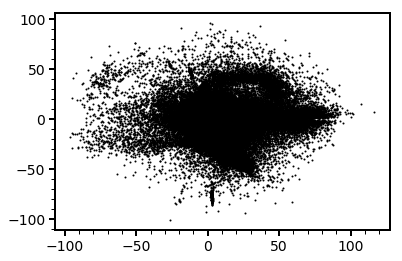

In [13]:
plt.scatter(xp,zp,color='black',s=1.)

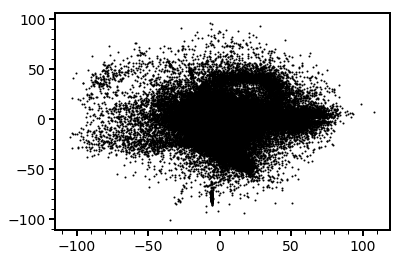

In [88]:
cbest = coord.SkyCoord(ra              = Gmatch['ra'][pmatch]    * u.deg,\
                       dec             = Gmatch['dec'][pmatch]   * u.deg,\
                       distance        = dist  * u.kpc)


#best_defined = cbest.transform_to(gc_frame)
best_sgr     = cbest.transform_to(Sagittarius)
best_latlon  = cbest.transform_to('galactic')

plt.scatter(best_defined.x,best_defined.z,color='black',s=1.)

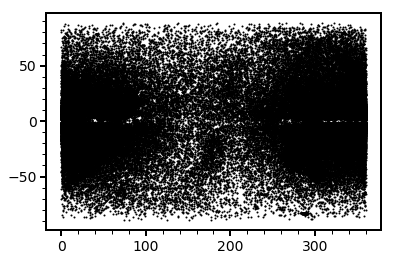

In [89]:
plt.scatter(best_latlon.l,best_latlon.b,color='black',s=1.)

In [150]:
indx = 11

a = Gmatch['ra'][pmatch][indx]*np.pi/180.
d = Gmatch['dec'][pmatch][indx]*np.pi/180.

#%timeit ricrs = return_ricrs(a,d)


In [151]:
ricrs = return_ricrs(a,d)
A = return_gaia_Agprime()
#%timeit rgal = np.dot(A,ricrs)

In [152]:
rgal = np.dot(return_gaia_Agprime(),ricrs)
print(rgal)
#%timeit np.dot(dist[indx],rgal)

[ 0.96237108 -0.2680665   0.04452247]


In [198]:
indx = 0
rotate_positions(Gmatch['ra'][pmatch][indx]*np.pi/180.,\
                                                        Gmatch['dec'][pmatch][indx]*np.pi/180.,\
                                                        dist[indx])

array([ 38.55669468, -10.56406227,   1.34040449])

In [ ]:
for indx in range(0,pmatch.size):
    if (indx % 1000 == 0): print(indx)
    xpos[indx],ypos[indx],zpos[indx] = rotate_positions(Gmatch['ra'][pmatch][indx]*np.pi/180.,\
                                                        Gmatch['dec'][pmatch][indx]*np.pi/180.,\
                                                        dist[indx])



In [4]:
!ls data/*Jorge*

data/Sgr_LAMOST_DR5_KG_obsid_forJorge.fits
data/lamost_kg_dr5_halo_forJorge.fits
data/lamost_kg_dr5_smoothhalo_forJorge.fits


In [54]:

C17 = np.genfromtxt('/Users/mpetersen/Notebooks/Dynamics/Shells/cohen17.txt',\
                        dtype={'names': ("sgr","per","hjd","ampr",\
                                         "rmag","nr","ng","qual",\
                                         "RA","Dec","dist","nsp",\
                                         "rvgsr","ervgsr","date"),\
                             'formats': ('S20','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'f8','f8','f8')},\
                 skip_header=66)





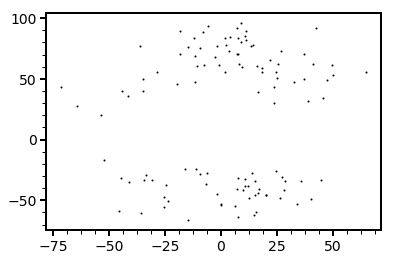

In [6]:
xpos,ypos,zpos = np.zeros(C17['RA'].size),np.zeros(C17['RA'].size),np.zeros(C17['RA'].size)

for indx in range(0,C17['RA'].size):
    xpos[indx],ypos[indx],zpos[indx] = rotate_positions(C17['RA'][indx]*np.pi/180.,C17['Dec'][indx]*np.pi/180.,C17['dist'][indx])

plt.scatter(xpos,zpos,color='black',s=1.)

In [301]:
Gmatch["source_id"]

array([b'90198608955264', b'205780473330048', b'219219426355200', ...,
       b'6912668773929549056', b'6912692177207121024',
       b'6912944824363453568'], dtype='|S20')

In [33]:
Gmatch = np.genfromtxt('/Users/mpetersen/Downloads/cohen17_corr-result.csv',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmra_pmdec_corr","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

In [6]:

# now with RUWE!
Gmatch = np.genfromtxt('/Users/mpetersen/Downloads/cohen_corr_ruwe-result.csv',\
                        dtype={'names': ("dec","parallax","dist","parallax_error",\
                                         "phot_bp_mean_flux_error","bp_rp","pmra","a_g_val","ra_error",\
                                         "pmra_error","pmdec_error","radial_velocity_error","pmra_pmdec_corr",\
                                         "teff_val","phot_g_mean_flux","phot_variable_flag","ra",\
                                         "phot_bp_mean_flux","phot_g_mean_flux_error","radial_velocity",\
                                         "dec_error","name","pmdec","phot_g_mean_mag","ruwe","source_id"),\
                             'formats': ('f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8',\
                                         'f8','S20','f8','f8','f8','S20')},\
                 skip_header=1,delimiter=',')

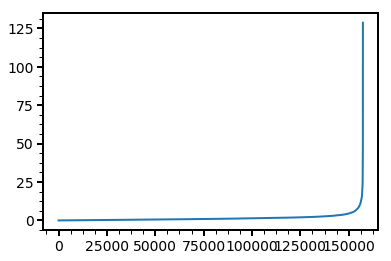

In [531]:
distsntmp = np.abs(Gmatch['parallax'])/Gmatch['parallax_error']
distsn = distsntmp[pmatch]

plt.plot(distsn[distsn.argsort()])


In [7]:
print(Gmatch['pmra'])

[ 1.45704100e-01  9.98221472e-01  1.38968430e+00  1.61170607e+00
  1.37519893e-01  8.63302488e-01  2.02880589e+00 -3.26448513e-01
  1.20673143e+00 -5.40916984e-01  5.97188059e-02 -7.59628445e-01
  1.12499522e-01 -2.09915889e+00  2.44248573e+00 -3.70089614e-01
             nan -9.98909758e-01  2.35620894e-01 -3.32040356e+00
  7.76109823e-01 -1.02002135e+00 -7.07290084e-01  1.37939743e-01
 -3.98076169e-01  1.28738262e+00 -1.68618497e+00  5.69475392e-01
  2.31309070e-01 -3.57790302e-01 -3.57499424e-01 -1.97831562e+00
 -2.03608660e+00 -1.08220667e+00 -1.03088036e+00  3.86908124e-01
 -2.18327745e+00 -1.28738679e-01  5.48337525e-01  3.72803787e-01
  5.77204210e-01 -1.65210026e-01 -2.48595031e-01 -1.17491914e+00
  4.00037438e-02 -1.86754095e+00 -2.32854532e-02  2.93757157e+00
 -1.91772263e+00 -1.85942300e+00 -1.04476640e+00 -1.03777563e+00
  7.14448340e-01 -4.57584685e-01 -1.34338381e+00 -3.62150948e-03
 -3.85725039e-01 -2.67209485e-01  2.80816590e-02  1.24527553e+00
 -2.14104431e-01 -1.01594

In [46]:
print(Gmatch['ruwe'])

[1.0595022  1.0558776  1.0309095  0.94892    1.0455922  0.91754687
 1.034767   0.90555215 0.9552674  1.0879066  1.066541   1.0535487
 1.0600315  0.98340374 1.0113455  1.1398855         nan 0.9542892
 1.0073326  0.99274445 0.9779225  1.0434934  0.9825461  0.9488022
 1.0436572  1.0194228  0.983159   1.0240927  0.95504886 0.95698786
 0.9352879  1.0328686  1.0140067  1.0069655  0.97808886 0.99326
 1.0117781  1.0164856  0.93398935 0.9754205  1.0094391  0.9959188
 1.0042089  0.9833959  0.9895391  1.0593865  0.94511944 1.0766734
 0.9551718  0.94484526 1.061316   1.0529302  1.1190357  1.0467572
 1.045499   0.9279445  0.9647465  1.0197444  0.87253517 1.1346891
 0.9203129  0.9469259         nan 1.2104374  0.9886527  0.90944016
 1.0068961  0.99320287 0.95123607 0.9975518  0.99278754 1.0074794
 1.0018101  0.91265106        nan 1.0334768  1.1660376  0.96323776
 0.86215675 1.085313   0.97515935        nan 0.9764313  1.0193242
        nan 1.0569     1.1703418         nan 0.97319376 0.9740569
 0.94781

In [41]:
Gmatch['xsource_id'].astype('S20')
xsources = [int(d.decode()) for d in Gmatch['xsource_id']]

ValueError: invalid literal for int() with base 10: '0.3241104334145973'

In [35]:
pmatch = []
for i in obsid:
    #print(i,xsources[0:10])
    w = np.where(xsources==i)[0]
    #print(w,w.size)
    if w.size>1:
        print(i,w,Gmatch['dist'][w],w[np.nanargmin(Gmatch['dist'][w])])
        pmatch.append(w[np.nanargmin(Gmatch['dist'][w])])
    else:
        pmatch.append(w[0])
    #print(w.size)

NameError: name 'obsid' is not defined

54


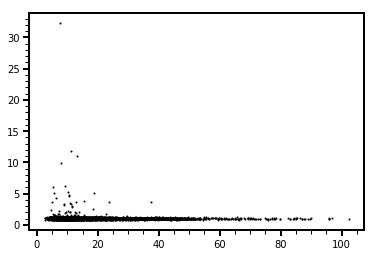

In [127]:
plt.scatter(dist,Gmatch['ruwe'][pmatch],color='black',s=1.)
bigruwe = np.where(Gmatch['ruwe'][pmatch]>=1.4)[0]
print(bigruwe.size)
goodruwe = np.where(Gmatch['ruwe'][pmatch]<1.4)[0]

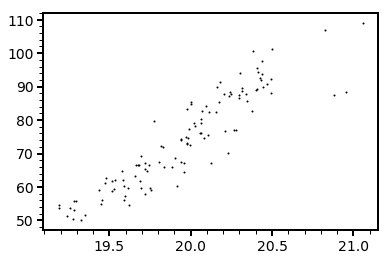

In [13]:
plt.scatter(Gmatch['phot_g_mean_mag'],C17['dist'],color='black',s=1.)

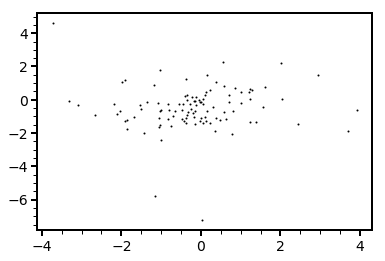

In [14]:
bigd = np.where(C17['dist']>40)

k = 4.74057
vra = Gmatch['pmra']

plt.scatter(Gmatch['pmra'][bigd],Gmatch['pmdec'][bigd],color='black',s=1.)

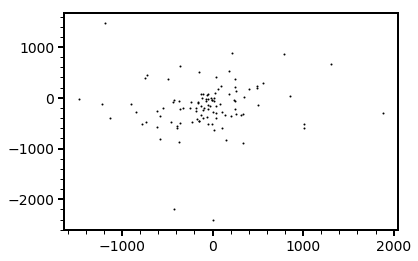

In [16]:
k = 4.74057
vra = Gmatch['pmra']*C17['dist']*k
vdec = Gmatch['pmdec']*C17['dist']*k

plt.scatter(vra,vdec,color='black',s=1.)


In [87]:
# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 220.
#vcirc = 244.
#vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 20 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)




In [52]:

ra = C17['RA']
dec = C17['Dec']
dist = C17['dist']
edist = 0.1*C17['dist']
rv = C17['rvgsr']
erv = C17['ervgsr']


def find_errors(indx,nsamples=10000,verbose=False,sgr=False):
    rat = ra[indx]
    dect = dec[indx]
    dt = dist[indx]
    derrt = edist[indx]
    pmrat = Gmatch['pmra'][indx]
    pmraerrt = Gmatch['pmra_error'][indx]
    pmdect = Gmatch['pmdec'][indx]
    pmdecerrt = Gmatch['pmdec_error'][indx]
    vradt = rv[indx]
    vraderrt = erv[indx]
    
    print(rat,dect,dt)

    cplus = coord.SkyCoord(ra              = np.tile(rat,nsamples)                                 * u.deg,\
                           dec             = np.tile(dect,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(dt     + np.random.normal(size=nsamples)*derrt)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmrat  + np.random.normal(size=nsamples)*pmraerrt)  * u.mas/u.yr,\
                           pm_dec          = (pmdect + np.random.normal(size=nsamples)*pmdecerrt) * u.mas/u.yr,\
                           radial_velocity = (vradt  + np.random.normal(size=nsamples)*vraderrt)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = rat    * u.deg,\
                           dec             = dect   * u.deg,\
                           distance        = dt     * u.kpc,\
                           pm_ra_cosdec    = pmrat  * u.mas/u.yr,\
                           pm_dec          = pmdect * u.mas/u.yr,\
                           radial_velocity = vradt  * u.km/u.s)

    if verbose:
        print(pmrat,pmdect,vradt)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    if sgr:
        best_sgr = cbest.transform_to(Sagittarius)
        return gal_latlon,gal_defined,best_latlon,best_defined,best_sgr
    
    else:
        return gal_latlon,gal_defined,best_latlon,best_defined


indx = 0
gal_latlon,gal_defined,best_latlon,best_defined = find_errors(indx,nsamples=1000,verbose=False)

gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(indx,nsamples=1000,verbose=True,sgr=True)


print(best_defined)

print(best_latlon)
print(best_sgr)


NameError: name 'C17' is not defined

In [27]:
Gmatch['pmra'][1]

-0.13741135573919835

In [24]:
indx = 2
rotate_velocities(ra[indx]*np.pi/180.,dec[indx]*np.pi/180.,Gmatch['pmra'][indx],Gmatch['pmdec'][indx])




(0.8034036103591531, -0.6868023136201)

In [29]:
cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                       dec             = dec   * u.deg,\
                       distance        = dist  * u.kpc,\
                       pm_ra_cosdec    = Gmatch['pmra']  * u.mas/u.yr,\
                       pm_dec          = Gmatch['pmdec'] * u.mas/u.yr,\
                       radial_velocity = rv  * u.km/u.s)

best_defined = cbest.transform_to(gc_frame)
best_sgr     = cbest.transform_to(Sagittarius)
best_latlon  = cbest.transform_to('galactic')

plt.scatter(best_defined.x,best_defined.z,color='black',s=1.)

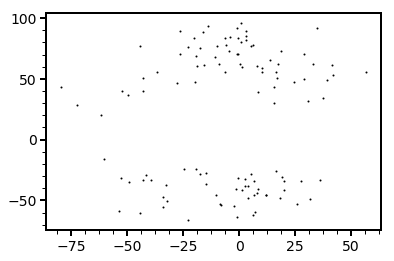

In [34]:
# back out the rotated correlation coefficients

pmatch = np.arange(0,len(Gmatch['pmra_error']),1)
pm_l_err = np.zeros(len(pmatch))
pm_b_err = np.zeros(len(pmatch))
corrcoef = np.zeros(len(pmatch))
pm_l     = np.zeros(len(pmatch))
pm_b     = np.zeros(len(pmatch))

for i in range(0,len(pmatch)):
    #print(i)
    e1 = Gmatch['pmra_error'][i]
    e2 = Gmatch['pmdec_error'][pmatch][i]
    e3 = Gmatch['pmra_pmdec_corr'][pmatch][i]
    cov_to = rotate_errors(Gmatch['ra'][pmatch][i]*np.pi/180.,Gmatch['dec'][pmatch][i]*np.pi/180.,\
                       e1,e2,e3)
    
    corrcoef[i] = cov_to[0][1]/(np.sqrt(cov_to[0][0])*np.sqrt(cov_to[1][1]))
    pm_l_err[i] = np.sqrt(cov_to[0][0])
    pm_b_err[i] = np.sqrt(cov_to[1][1])
    
    lbvel = rotate_velocities(Gmatch['ra'][pmatch][i]*np.pi/180.,Gmatch['dec'][pmatch][i]*np.pi/180.,\
                              Gmatch['pmra'][pmatch][i],Gmatch['pmdec'][pmatch][i])
    
    pm_l[i] = lbvel[0]
    pm_b[i] = lbvel[1]






In [50]:

f = open('/Users/mpetersen/Dropbox/mike/data/CohenRRL.txt','w')

print("x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s];      l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];       edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]",file=f)

rej = 0
for i in range(0,len(pmatch)):
    if (Gmatch['ruwe'][pmatch][i] < 1.4) & (np.isfinite(np.array(best_defined.v_y)[i])):
        print(np.array(best_defined.x)[i],np.array(best_defined.y)[i],np.array(best_defined.z)[i],\
              np.array(best_defined.v_x)[i],np.array(best_defined.v_y)[i],np.array(best_defined.v_z)[i],\
              np.array(best_latlon.l)[i],np.array(best_latlon.b)[i],dist[i],\
              rv[i],pm_l[i],pm_b[i],\
              edist[i],erv[i],pm_l_err[i],pm_b_err[i],\
              0,0,0,\
              np.array(best_sgr.Lambda)[i],np.array(best_sgr.Beta)[i],0,\
              corrcoef[i],file=f)
    else:
        rej +=1
        print('REJECTED!')
    
          
f.close()
print(rej)


REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
15


In [5]:
Gmatch['radial_velocity'].size

363969

In [6]:
np.unique(Gmatch['best_class_name'])

array([b'ACEP', b'ARRD', b'CEP', b'DSCT_SXPHE', b'MIRA_SR', b'RRAB',
       b'RRC', b'RRD', b'T2CEP'], dtype='|S20')

157347


In [37]:
grvs = Gmatch['radial_velocity'][pmatch][np.isfinite(Gmatch['radial_velocity'][pmatch])]
print(grvs.size)

368


(0.0, 5.0)

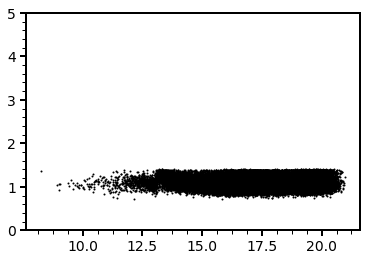

In [38]:
plt.scatter(Gmatch['phot_g_mean_mag'][pmatch],Gmatch['ruwe'][pmatch],color='black',s=1.)

plt.ylim(0.,5.)


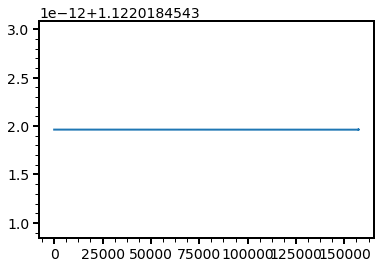

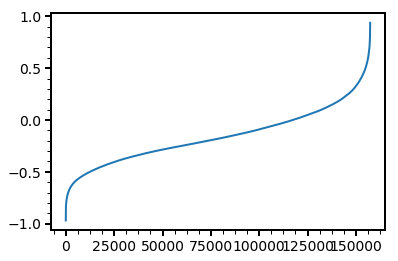

In [475]:




f = open('/Users/mpetersen/Dropbox/mike/data/RRL_GaiaI_all_sub.txt','w')

print("x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];       edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];      Ramos Strip [bool]; Ramos Pole [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]; rlmc [kpc]; lmcflag [bool]; rsmc [kpc]; smcflag [bool]; Sat member [bool]; GC member [bool]",file=f)

# olap1 is pole, olap2 is trip
rej = 0
acc = 0
for i in range(0,len(pmatch)):
    #print(np.abs((np.array(best_latlon.b)[i])))
    if (Gmatch['ruwe'][pmatch][i] < 1.4) & (np.abs(np.array(best_latlon.b)[i])>10.):
        print(np.array(best_defined.x)[i],np.array(best_defined.y)[i],np.array(best_defined.z)[i],\
              #np.array(best_defined.v_x)[i],np.array(best_defined.v_y)[i],np.array(best_defined.v_z)[i],\
              0,0,0,\
              np.array(best_latlon.l)[i],np.array(best_latlon.b)[i],dist[i],\
              0.,pm_l[i],pm_b[i],\
              0.1*dist[i],0.,pm_l_err[i],pm_b_err[i],\
              olap2[i],olap1[i],0,\
              np.array(best_sgr.Lambda)[i],np.array(best_sgr.Beta)[i],0,\
              corrcoef[i],rlmc[i],lmcflag[acc],rsmc[i],smcflag[acc],sat_member[acc],gc_member[acc],file=f)
        acc +=1
    else:
        rej +=1
        #print('REJECTED!')
    
          
f.close()
print(acc,rej)



105866 51481


0 x [kpc]
1  y [kpc]
2  z [kpc]
3  vx [km/s]
4  vy [km/s]
5  vz [km/s]
6  l [deg]
7  b [deg]
8  dist [kpc]
9  vlos [km/s]
10  dmu_l [marcsec/yr]
11  dmu_b [marcsec/yr]
12        edist[kpc]
13  evlost [km/s]
14  edmu_l [marcsec/yr]
15  edmu_b [marcsec/yr]
16       Ramos Strip [bool]
17  Ramos Pole [bool]
18  FeH [dex]
19  Sgr Lambda [deg]
20  Sgr Beta [deg]
21  Belokurov Flag [bool]
22  corrcoef [-1:1]
23  rlmc [kpc]
24  lmcflag [bool]
25  rsmc [kpc]
26  smcflag [bool]
27  Sat member [bool]
28  GC member [bool]



In [13]:
RRL1[:,17]

array([0., 0., 0., ..., 0., 0., 0.])

In [514]:
rgood = np.where((RRL1[:,27]==1)&(RRL1[:,28]==1))[0]
print(rgood.size)

5


In [518]:
print(np.nanmax(RRL1[:,28]))

2.0


33448


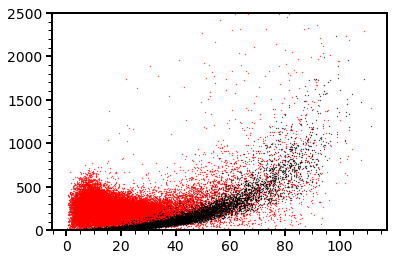

105866


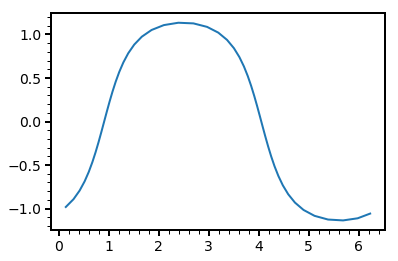

In [528]:


from reflexmotion import modelsats as ms
PHIP           = 178.45* np.pi/180.0;
THETA          = 114.89* np.pi/180.0;
PSI            = 54.05* np.pi/180.0;

PSI            = 9.05* np.pi/180.0;


Trans = ms.return_euler_slater(PHIP, THETA, PSI, 0)

phitest = np.linspace(1.42*np.pi,2.3*np.pi,50)

phitest = np.linspace(0.*np.pi,2*np.pi,50)

In0 = np.cos(phitest);
In1 = np.sin(phitest);
In2 = 0.0;
twisted  = np.dot(Trans,np.array([In0,In1,In2]))

#plt.plot(In0,In1)
#plt.plot(twisted[0],twisted[1])

lvals = -np.arctan2(twisted[1],twisted[0]) - 47.*np.pi/180.
bvals = -np.arcsin(twisted[2])

lvals[lvals<0]+=2.*np.pi

bvals = bvals[lvals.argsort()]
lvals = lvals[lvals.argsort()]

plt.plot(lvals,bvals)

24.339225542321596


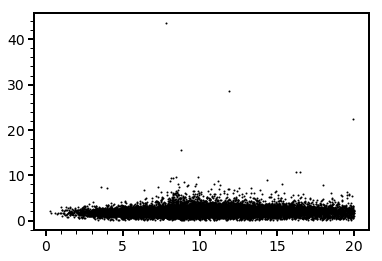

In [385]:
# make cuts around the LMC/SMC positions

lmcx = -0.62
lmcvx = -39.47
lmcy = -42.11
lmcvy = -229.29
lmcz = -27.69
lmcvz = 230.24
    
smcx = 16.35
smcvx = 7.77
smcy = -38.5
smcvy = -191.2 
smcz = -44.76
smcvz = 171.71

rlmc = np.sqrt((xp-lmcx)**2. + (yp-lmcy)**2. + (zp-lmcz)**2.)
rsmc = np.sqrt((xp-smcx)**2. + (yp-smcy)**2. + (zp-smcz)**2.)
rlmcsmc = np.sqrt((lmcx-smcx)**2. + (lmcy-smcy)**2. + (lmcz-smcz)**2.)
print(rlmcsmc)

lmc_candidates = np.where(rlmc<20)[0]
plt.scatter(rlmc[lmc_candidates],np.sqrt(pm_l**2.+pm_b**2.)[lmc_candidates],color='black',s=1.)

smc_candidates = np.where(rsmc<10)[0]
#plt.scatter(xp[smc_candidates],zp[smc_candidates],color='red',s=1.)

31 32 31


9540 5789.0 3751.0


In [273]:
smallest_rsat = 100.*np.ones(RRL1[:,0].size)

smallest_rsat = np.nanmin([rsat,smallest_rsat],axis=0)


for sat in range(0,nsats):
    rsat = np.sqrt((RRL1[:,0]-xsat[sat])**2. + (RRL1[:,1]-ysat[sat])**2. + (RRL1[:,2]-zsat[sat])**2. )
    smallest_rsat = np.nanmin([rsat,smallest_rsat],axis=0)
    #print(smallest_rsat[0:10])

In [373]:
w = np.where(RRL1[:,23]<25)
print(RRL1[w,6])
llmc,blmc = np.nanmedian(RRL1[w,6]),np.nanmedian(RRL1[w,7]),np.nanmedian(RRL1[w,8])
#sp_dist = spatial_distance(llmc,RRL1[w,6],blmc,RRL1[w,7])
#print(sp_dist)
print(llmc,blmc)

[[277.52677714 277.41102414 277.36041071 ... 281.8397409  281.7855956
  281.76700071]]
280.3497698382291 -32.951809774584234


In [428]:
print(llmc,blmc,dlmc)
280.4652 -32.8884

280.2044060851661 -32.936394774374214 53.94778276072235


258.4807

22696
2739


[0, 360, -90, 90]

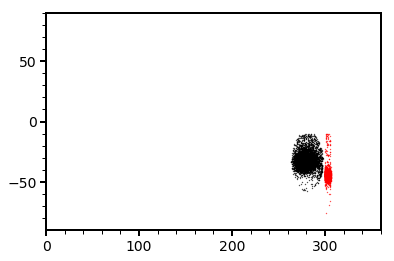

Antlia2 0
Aquarius2 0
Bootes1 4
Bootes2 1
CanesVenatici1 0
CanesVenatici2 0
Carina 6
Carina2 67
Carina3 32
Columba1 0
ComaBerenices 1
Crater2 1
Draco 102
Draco2 8
Eridanus2 0
Fornax 0
Grus1 0
Grus2 8
Hercules 0
Horologium1 1
Horologium2 0
Hydra2 0
Hydrus1 42
Leo1 0
Leo2 0
Leo4 0
Leo5 0
LeoT 0
Phoenix 0
Phoenix2 1
Pisces2 0
Reticulum2 5
Reticulum3 0
Sagittarius2 5
Sculptor 263
Segue1 4
Segue2 1
Sextans1 18
Triangulum2 18
Tucana2 4
Tucana3 3
Tucana4 6
Tucana5 8
UrsaMajor1 3
UrsaMajor2 6
UrsaMinor 68


In [64]:
print(np.nansum(sat_member))

686.0


[0, 360, -90, 90]

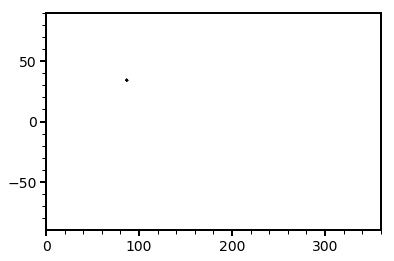

In [458]:
rgood = memberdict['Draco']
#print(rgood)

plt.scatter(RRL1[rgood,6],RRL1[rgood,7],color='black',s=0.1)

plt.axis([0,360,-90,90])



[0, 360, -90, 90]

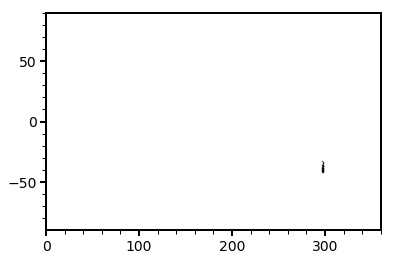

In [459]:
rgood = memberdict['Hydrus1']
#print(rgood)

plt.scatter(RRL1[rgood,6],RRL1[rgood,7],color='black',s=0.1)

plt.axis([0,360,-90,90])



5.306409911631421 kpc


Text(0, 0.5, 'z [kpc]')

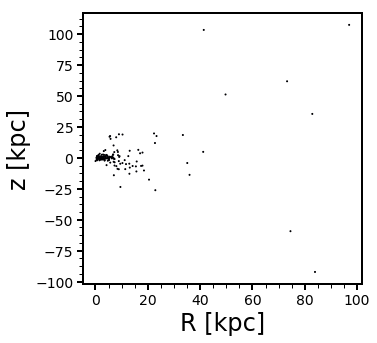

In [460]:

#RAJ2000;DEJ2000;GLON;GLAT;gmag;u-g;D0.2;fm;cHg;bHg;d;r;x;y;z;HRV;e_HRV;Vgal;DR8;Sloan;SimbadName


# set the coordinates
usun = 11.1
vsun = 12.24
wsun = 7.25
vcirc = 235.
rsun = 8.3 # in kpc
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)

# set up coordinates and transform to the frame we want

c = coord.SkyCoord(ra=V19['ra']*u.deg,\
                   dec=V19['dec']*u.deg,\
                   distance=V19['dist']*u.kpc,\
                   pm_ra_cosdec=V19['pmra']*u.mas/u.yr,\
                   pm_dec=V19['pmdec']*u.mas/u.yr,\
                   radial_velocity=V19['HRV']*u.km/u.s)


#gc1 = c.transform_to(coord.Galactocentric) # this is default galactic
gc1 = c.transform_to(gc_frame) # for specific coordinates set above
#print(gc1.x,gc1.v_x, gc1.v_y, gc1.v_z)

# plot the transformed velocities of the kept stars
plt.figure(figsize=(5,5))

plt.scatter(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y),gc1.z,color=cm.magma((np.array(gc1.v_z)+np.nanmin(np.array(gc1.v_z)))/(2.*np.nanmax(np.array(gc1.v_z))),1.),s=1.)
#plt.scatter(gc1.x,gc1.y,color='black',s=1.)

print(np.nanmedian(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y + gc1.z*gc1.z)))

plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')

In [461]:
print(np.nanmin(V19['dist']))

2.2


NGC 104 0
NGC 288 60
NGC 362 1
Whiting 1 0
NGC 1261 1
Pal 1 1
E 1 0
Eridanus 0
Pal 2 2
NGC 1851 3
NGC 1904 1
NGC 2298 5
NGC 2419 0
Pyxis 1
NGC 2808 2
E 3 0
Pal 3 0
NGC 3201 3
Pal 4 0
Crater 0
NGC 4147 0
NGC 4372 0
Rup 106 0
NGC 4590 14
NGC 4833 3
NGC 5024 0
NGC 5053 1
NGC 5139 0
NGC 5272 1
NGC 5286 0
NGC 5466 2
NGC 5634 0
NGC 5694 1
IC 4499 0
NGC 5824 0
Pal 5 0
NGC 5897 2
NGC 5904 0
NGC 5927 0
NGC 5946 0
BH 176 0
NGC 5986 0
FSR 1716 0
Pal 14 0
BH 184 1
NGC 6093 3
NGC 6121 3
NGC 6101 0
NGC 6144 0
NGC 6139 2
Terzan 3 0
NGC 6171 2
ESO 452-11 0
NGC 6205 3
NGC 6229 0
NGC 6218 0
FSR 1735 1
NGC 6235 4
NGC 6254 0
NGC 6256 0
Pal 15 0
NGC 6266 3
NGC 6273 3
NGC 6284 0
NGC 6287 1
NGC 6293 7
NGC 6304 2
NGC 6316 1
NGC 6341 1
NGC 6325 7
NGC 6333 0
NGC 6342 2
NGC 6356 1
NGC 6355 3
NGC 6352 2
IC 1257 0
Terzan 2 2
NGC 6366 0
Terzan 4 0
BH 229 12
NGC 6362 1
NGC 6380 13
Terzan 1 4
Ton 2 4
NGC 6388 1
NGC 6402 0
NGC 6401 3
NGC 6397 0
Pal 6 3
NGC 6426 0
Djorg 1 0
Terzan 5 2
NGC 6440 28
NGC 6441 4
Terzan 6 8


[52.97224756 50.13781459 45.99563299 48.78278607 45.83261111 52.36250321
 49.90069565 58.41166691 46.15304932 49.92890022 46.16091406 48.36063559
 40.87208567 51.60576258 50.23541565 49.77487752 48.92215733 61.50955711
 51.74752702 49.95205965 57.36087928 49.5062921  54.55894954 51.88246479
 49.33491679 47.77886184 45.82037087 53.49943555 44.86995149 48.22459622
 49.60145315]


[0, 360, -90, 90]

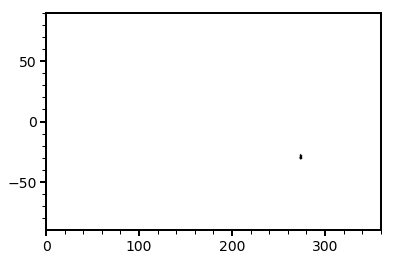

In [62]:
rgood = memberdictGC['BH 261']
#print(rgood)

plt.scatter(RRL1[rgood,6],RRL1[rgood,7],color='black',s=0.1)

print(RRL1[rgood,8])

plt.axis([0,360,-90,90])


In [473]:
print(np.nansum(gc_member))

2092.0
